In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from circadian.plots import Actogram
from circadian.lights import LightSchedule
from circadian.models import Forger99, Jewett99, Hannay19, Hannay19TP

days_night = 3
days_day = 2
slam_shift = LightSchedule.ShiftWork(lux=300.0, days_on=days_night, days_off=days_day)

total_days = 30
time = np.arange(0, 24*total_days, 0.10)
light_values = slam_shift(time)

f_model = Forger99()
kj_model = Jewett99()
spm_model = Hannay19()
tpm_model = Hannay19TP()

equilibration_reps = 2
initial_conditions_forger = f_model.equilibrate(time, light_values, equilibration_reps)
initial_conditions_kj = kj_model.equilibrate(time, light_values, equilibration_reps)
initial_conditions_spm = spm_model.equilibrate(time, light_values, equilibration_reps)
initial_conditions_tpm = tpm_model.equilibrate(time, light_values, equilibration_reps)

ModuleNotFoundError: No module named 'circadian'

In [ ]:
trajectory_f = f_model(time, initial_conditions_forger, light_values)
trajectory_kj = kj_model(time, initial_conditions_kj, light_values)
trajectory_spm = spm_model(time, initial_conditions_spm, light_values)
trajectory_tpm = tpm_model(time, initial_conditions_tpm, light_values)

In [24]:
import sys
import matplotlib
import numpy as np
import pylab as plt
from pathlib import Path
from copy import deepcopy
from CIRCADIA.models import Hannay19
from .utils import cut_phases_12
from .lights import LightSchedule
from scipy.ndimage import gaussian_filter1d

def __init__(self,
             time_total: np.ndarray, # time in hours
             light_vals: np.ndarray, # light values or proxy should be the same length as time_total
             second_zeit: np.ndarray = None, # optional second zeitgeber to show on the right side
             ax=None, # Axis to plot on, if None a new figure is created
             threshold=10.0, # threshold for light on/off 
             threshold2=None, # threshold for light on/off for second zeitgeber
             opacity: float = 1.0, # opacity of the light on/off rectangles
             color: str = 'black', # color of the light on/off rectangles, for the below threshold values
             smooth=True, # whether to apply a gaussian filter to the light values to smooth it, useful for wearable data
             sigma=[2.0, 2.0], # sigma for the gaussian filter
             *args, # additional plot arguments
             **kwargs # additional plot keyword arguments
             ):

    self.time_total = time_total
    self.light_vals = light_vals
    self.num_days = np.ceil((time_total[-1] - time_total[0])/24.0)

    self.second_zeit = second_zeit if second_zeit is not None else light_vals

    if smooth:
        self.light_vals = gaussian_filter1d(
            self.light_vals, sigma=sigma[0])
        self.second_zeit = gaussian_filter1d(
            self.second_zeit, sigma=sigma[1])

    threshold2 = threshold if threshold2 is None else threshold2
    self.ax = ax if ax is not None else plt.gca()

    # Set graphical parameters
    label_scale = int(np.floor(self.num_days/30))
    if label_scale < 1:
        label_scale = 1

    self.opacity = opacity
    self.darkColor = color
    start_day = np.floor(self.time_total[0]/24.0)
    self.ax.set_ylim(start_day, self.num_days+start_day)
    self.ax.set_xlim(0, 48)
    self.ax.set_yticks(
        np.arange(int(start_day), self.num_days+1+start_day, label_scale))
    ylabels_list = list(range(int(start_day), int(
        self.num_days+start_day)+1, label_scale))
    # ylabels_list.reverse()

    self.ax.set_yticklabels(ylabels_list)
    self.ax.set_xticks(np.arange(0, 48+3, 3))
    xlabels_list = list(range(0, 27, 3))+list(range(3, 27, 3))
    self.ax.set_xticklabels(xlabels_list)
    self.ax.set_xticks(np.arange(0, 48, 1), minor=True)

    #self.ax.yaxis.grid(False, linewidth=1.0, color='k')
    # self.ax.xaxis.grid(False)

    self.ax.plot(24.0*np.ones(100), 
                 np.linspace(0, self.num_days,100), 
                 ls='--', 
                 lw=2.0, 
                 color='black', 
                 zorder=9)
    self.ax.set_xlabel("ZT")
    self.ax.set_ylabel("Days")

    self.addLightSchedule(self.light_vals, threshold,
                          plt_option='left', color=self.darkColor)
    self.addLightSchedule(self.second_zeit, threshold2,
                          plt_option='right', color=self.darkColor)
    self.ax.invert_yaxis()

def getRectangles(self, timeon, timeoff, colorIn='white'):
    bottom_x = np.fmod(timeon, 24.0)
    bottom_y = int(timeon/24.0)  # -1
    alpha = self.opacity if colorIn != 'white' else 0.0
    r1 = plt.Rectangle((bottom_x, bottom_y), timeoff -
                       timeon, 1, fc=colorIn, zorder=-1, alpha=alpha)
    r2 = plt.Rectangle((bottom_x+24.0, bottom_y),
                       timeoff-timeon, 1, fc=colorIn, zorder=1, alpha=alpha)
    return((r1, r2))

def addRect(self, timeon, timeoff, colorIn='white', plt_option='both'):
# Used to add a rectangle to the axes"""
    r = self.getRectangles(timeon, timeoff, colorIn)
    if plt_option == 'left':
        self.ax.add_patch(r[0])
        return
    if plt_option == 'right':
        self.ax.add_patch(r[1])
        return
    self.ax.add_patch(r[0])
    self.ax.add_patch(r[1])

def addLightSchedule(self, zeit: np.ndarray,
                     threshold: float,
                     plt_option: str = 'both',
                     color='black'):
    lightdata = zeit
    timedata = self.time_total
    lightsOn = False
    if (lightdata[0] > threshold):
        lightsOn = True
        lightStart = timedata[0]
    else:
        darkOn = True
        darkStart = timedata[0]

    dayCounter = int(timedata[0]/24.0)  # count the days in the data set
    for i in range(1, len(lightdata)):
        currentDay = int(timedata[i]/24.0)
        if (currentDay != dayCounter):
            dayCounter = currentDay
            if (lightsOn == True):
                self.addRect(
                    lightStart, timedata[i], plt_option=plt_option)
                if (i+1 < len(timedata)):
                    # reset the light counter to start over the next day
                    lightStart = timedata[i+1]
            else:
                self.addRect(
                    darkStart, timedata[i], colorIn=color, plt_option=plt_option)
                if (i+1 < len(timedata)):
                    darkStart = timedata[i+1]

        if (lightdata[i] < threshold and lightsOn == True):
            self.addRect(lightStart, timedata[i-1], plt_option=plt_option)
            lightsOn = False
            darkOn = True
            darkStart = timedata[i]
        if (lightsOn == False and lightdata[i] >= threshold):
            lightsOn = True
            lightStart = timedata[i]
            darkOn = False
            self.addRect(
                darkStart, timedata[i-1], colorIn=color, plt_option=plt_option)

def plot_phasemarker(self, phase_marker_times: np.ndarray,
                     error: np.ndarray = None,
                     alpha=1.0,
                     alpha_error=0.30,
                     scatter=False,
                     *args, **kwargs):
    
    # This method takes in a list of times which are assumed to occur at the same 
    # circadian phase (e.g. DLMO, CBTmin). These are plotted as points 
    # on the actogram.  
    #     plot_phasemarker(self, phase_marker_times: np.ndarray, *args, **kwargs)

    xvals = deepcopy(phase_marker_times)
    yvals = deepcopy(phase_marker_times)

    xvals = np.fmod(xvals, 24.0)
    yvals = np.floor(yvals / 24.0) + 0.5

    if scatter:
        self.ax.scatter(xvals, yvals, *args, **kwargs)
        self.ax.scatter(xvals+24.0, yvals, *args, **kwargs)

    idx_split = (np.absolute(np.diff(xvals)) > 6.0).nonzero()[0]+1
    xvals_split = np.split(xvals, idx_split)
    yvals_split = np.split(yvals, idx_split)
    if error is not None:
        error_split = np.split(error, idx_split)

    for (idx, xx) in enumerate(xvals_split):
        self.ax.plot(xx, yvals_split[idx], alpha=alpha, *args, **kwargs)
        self.ax.plot(
            xx+24.0, yvals_split[idx], alpha=alpha, *args, **kwargs)
        if error is not None:
            self.ax.fill_betweenx(
                yvals_split[idx], xx-error_split[idx], xx+error_split[idx], alpha=alpha_error, *args, **kwargs)
            self.ax.fill_betweenx(
                yvals_split[idx], xx-error_split[idx]+24.0, xx+error_split[idx]+24.0, alpha=alpha_error, *args, **kwargs)

def plot_phasetimes(self, 
                    times: np.ndarray, 
                    phases: np.ndarray, 
                    error: np.ndarray = None,
                    alpha_error=0.30, 
                    alpha=1.0, 
                    *args, 
                    **kwargs):
        # This method takes observations of the phase and times (same length arrays)
        # and adds them to the actogram.    
  xvals = deepcopy(phases)
xvals = np.arctan2(np.sin(xvals), np.cos(xvals))
for i in range(len(xvals)):
    if xvals[i] < 0.0:
        xvals[i] += 2*np.pi

xvals = np.fmod(xvals, 2*np.pi)
xvals *= 12.0/np.pi

xvals = np.fmod(xvals, 24.0)
yvals = deepcopy(times)
yvals = np.floor(yvals / 24.0) + 0.5

idx_split = (np.absolute(np.diff(xvals)) > 6.0).nonzero()[0]+1
xvals_split = np.split(xvals, idx_split)
yvals_split = np.split(yvals, idx_split)
if error is not None:
    error_split = np.split(error, idx_split)

for (idx, xx) in enumerate(xvals_split):
    self.ax.plot(xx, yvals_split[idx], alpha=alpha, *args, **kwargs)
    self.ax.plot(
        xx+24.0, yvals_split[idx], alpha=alpha, *args, **kwargs)
    if error is not None:
        self.ax.fill_betweenx(
            yvals_split[idx], xx-error_split[idx], xx+error_split[idx], alpha=alpha_error, *args, **kwargs)
        self.ax.fill_betweenx(
            yvals_split[idx], xx-error_split[idx]+24.0, xx+error_split[idx]+24.0, alpha=alpha_error, *args, **kwargs)


ImportError: attempted relative import with no known parent package

In [14]:
acto = Actogram(time, light_vals=light_values, opacity=1.0, smooth=False)
acto.plot_phasemarker(dlmo_f, color='blue')
acto.plot_phasemarker(dlmo_spm, color='darkgreen')
acto.plot_phasemarker(dlmo_tpm, color='red')
acto.plot_phasemarker(dlmo_kj, color='purple')
# legend
blue_line = lines.Line2D([], [], color='blue', label='Forger99')
green_line = lines.Line2D([], [], color='darkgreen', label='Hannay19')
red_line = lines.Line2D([], [], color='red', label='Hannay19TP')
purple_line = lines.Line2D([], [], color='purple', label='Jewett99')

plt.legend(handles=[blue_line, purple_line, green_line, red_line], 
           loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=4)
plt.title("Actogram for a Simulated Shift Worker", pad=35)
plt.tight_layout()
plt.show()

NameError: name 'Actogram' is not defined

In [34]:
############################################
# This is the definition of the ODE class. #
#  With this class you can define an ODE   #
#    system (originally developed for      #
#   circadian rhythms) with which you can  #
# perform phase response analysis on. The  #
# class uses the direct an iPRC methods of #
#  calculating the phase response curve.   #
#    The main function of this class is    #
#      phase response optimization.        #
#        Jacob Bellman, 3/1/2015           #
############################################

#Import libraries potentially required for computation
from __future__ import print_function
import sys
import sympy
from mpmath import *
from sympy.utilities.lambdify import lambdify
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import argrelextrema
from numpy import linalg as LA
import time
import matplotlib
from matplotlib.ticker import FormatStrFormatter
import scipy.optimize
from scipy.signal import argrelextrema
from scipy.optimize import minimize_scalar

class ODE:
    """
    The initializer of the ODE class requires a string name (name),
    the index of frq mRNA (frq_ind), a matrix of sympy variables 
    (variables), a dictionary of sympy parameters and their values 
    (parameters), a list of sympy parameters that act as placeholders 
    for constant pulses to RHS functions (par_add), a matrix of sympy ODE 
    RHS functions (RHS), values of the variables on the limit cycle at 
    the maximum value of frq mRNA (lim_cyc_vals) and the period of the
    limit cycle in hours (period).                      """
    def __init__(self, name, frq_ind, variables, parameters, par_add,
                 RHS, lim_cyc_vals, period, findQ=True):
        
        # Initialize all inputs
        self.name = name
        self.frq_ind = frq_ind
        self.save_name = self.name.replace(" ", "")
        self.variables = variables
        self.num_vars = len(variables)
        self.parameters = parameters
        self.num_parms = len(parameters)
        self.par_add = par_add
        self.RHS = RHS
        self.lim_cyc_vals = lim_cyc_vals
        
        # All models will have the time variable t.      
        self.t = sympy.Symbol('t')

        #######################################################
        #  Create numpy functions, non symbolic, for the RHS  #
        #  as well as the jacobian wrt the variables as well  #
        #                 as the parameters                   #
        #######################################################

        # Convert the RHS sympy func to a numpy func        
        self.f_ODE_RHS = self.RHStoFunc()
        
        #Necessary for iPRC analysis (only valid for small pulses)
        if (findQ == True):
            # Find the iPRCs (Q_interp) of the ODE along with associated
            # solutions (Y_interp), both necessary for PRC calculation.                  
            [self.Q_interp, self.Y_interp]  = self.findQ_interpAndY_interp()
        
        # Find the limit cycle solution y_gamma on a very fine grid
        # as well as the period to be use with dirPRC calculation.
        step_size_this = 10e-3 
        
        #self.period = self.findPeriod(step_size_this)
        self.period = period        
    
    #############################################################    
    #############################################################
    ######                                                #######
    ######  METHODS FOR THE ODE CLASS (ALPHABETIC ORDER)  #######  
    ######                                                #######
    #############################################################
    #############################################################

#---------------------------------------------------------------------
    
    #This function is used to define additive pulses (see dirPRC) 
    def addParsToRHS(self, pulses_add):

        # In the RHS function, incorporate all additive pulses.
        def f_RHS_add(Y,t,p):
           
            # The unpulsed RHS (in terms of additive pulses):                
            a = self.f_ODE_RHS(Y,t,p)
            
            # A vector to be filled with corresponding additive pulses:
            b = np.zeros(a.shape)
            for this_par in pulses_add:
                this_par_amp = pulses_add[this_par]
                this_par_ind = self.par_add.index(this_par)
                
                # If for some reason the variable is negative, don't
                # decrease it
                if (Y[this_par_ind]<=0) and (this_par_amp<0):
                    
                    b[this_par_ind] = 0
                    
                else:
                    
                    b[this_par_ind] = this_par_amp
        
            return a+b
            
        return f_RHS_add

#---------------------------------------------------------------------

    ####################################################################
    # ApproxPRC computes an approximate PRC using the iPRCs (Q_interp) #
    #       of an ODE given a vector of phases at which to pulse       #
    # (time_points), a dictionary of symbolic parameters to be pulsed  #
    # with their corresponding amplitudes (pulses), and the length of  #
    #                       the pulse (sigma).                         #
    ####################################################################
    
    # PRC pulsing parameter with index p_ind and amplitude amp
    def approxPRC(self,time_points,pulses,sigma):
        
        # If the pulse is being added to the RHS of the ODE, J_p will be 1
        # for the variable pulsed, and 0 for the rest. The integrand then is 
        # (the amplitude of the pulse) *  (Q). For this reason, we approx this
        # PRC using amp*Q(phi)*sigma as Q is approximately the average of Q on the
        # interval [phi, phi+sigma] when sigma is small.
        def PRCAdd(p_ind,amp):   
            
            prc_add_out = sigma*amp*self.Q_interp(time_points)[:,p_ind]
            
            return prc_add_out
        
        # This function uses the convolution integral to determine the PRC in 
        # response to a pulse of specific parameters. Input a dictionary of
        # parameters to be pulsed and their corresponding amplitudes.        
        def PRCPar(par_pulses):

            # Initialize the prc yielded from pulsing these indicies            
            prc_par_out = np.zeros(time_points.shape)    
        
            # pulse def 
            def dp(u):
                
                pulse_start = 0.
                pulse_end = sigma
                
                # Initialize output.                    
                y = np.zeros((self.num_parms))                 
                
                # Only on the interval of the pulse, dp is a function that
                # returns an array of 0s for indicies corresponding to non
                # pulsed parameters, and the amplitude of the pulse for the
                # indicies of the pulsed parameters                 
                if (u > pulse_start) & (u < pulse_end):
                    
                    for this_par in par_pulses:
                        this_amp = par_pulses[this_par]
                        this_ind = self.parameters.keys().index(this_par)
                        y[this_ind] = this_amp
                
                return y     
            
            for ind, val in enumerate(time_points):

                #integrand for PRC, ( Q dot Jac_p(Y) ) * dp
                def f(u):
                    
                    Q =  self.Q_interp(u + val)
                    Jac_p = self.f_dYdp(self.Y_interp(u + val),
                                        u, self.parameters.values())
                    y = np.dot(np.dot(Q,Jac_p), dp(u))
    
                    return y
                
                shift, err = integrate.quad(f, 0, sigma)
                            
                prc_par_out[ind] = shift                
                
            return prc_par_out

        ###############################################################
        # Now we will find the PRC using the above 2 functions. First #
        #       we will add all of the PRCs from pulsing additive     #
        #   constants using PRCAdd, and with the remaining indicies   #
        # we can find the PRC from pulsing the rest of the parameters #
        #                   all at once using PRCPar.                 #
        ###############################################################       
        
        # Initialize the PRC
        prc_vec = np.zeros(time_points.shape)
        
        # Initialize a dictionary of pulses (parameters and correspoinding
        # amplitudes) that affect parameters as opposed to par_add
        # parameters.
        par_pulse_dic = {} 

        # Determine the indicies of parameters in parameters and par_add
        # affected by the pulse and add these prcs to prc_vec. If the current
        # parameter is in parameters, add it and the corresponding amp to
        # par_pulse_dic.
        for this_par in pulses:
            
            # Name the current pulse amplitude.            
            this_amp = pulses[this_par]
            
            # If this parameter is in par_add, add the PRC to prc_vec
            if (this_par in self.par_add) == True:                
                # Need to input the index corresponding to par_add                
                this_ind = self.par_add.index(this_par)
                prc_vec += PRCAdd(this_ind,this_amp)
            
            # If not in par_add, it affects a parameter. Add the parameter
            # and the corresponding amplitude of this parameter pulse to 
            # the dictionary par_pulse_dic.
            elif (this_par in self.parameters.keys()) == True:
                
                par_pulse_dic[this_par] = this_amp
            
            # Tell the user if this parameter was entered incorrectly.
            else:
                
                str1 = str(this_par)
                str2 = ' is not an acceptable parameter'
                print(''.join([str1, str2]))
        
        # This means there is at least one pulsing parameter in pulses
        # affecting parameters as opposed to par_add. Add the PRC resulting
        # from the pulses affecting these parameters to prc_vec.
        if (not par_pulse_dic) == False:
            
            prc_vec += PRCPar(par_pulse_dic)
            
        # Lastly, mod out correctly to ensure the PRC is in the interval 
        # [-period/2, period/2]
        prc_vec_out = (prc_vec + self.period/2.) % \
                      (self.period) - self.period/2.        
        
        return prc_vec_out      

#---------------------------------------------------------------------
    def changePars(self, pulses_pars):

        # change parameters for the pulse. Don't forget to change them back
        for this_par in pulses_pars:
            
            this_amp = pulses_pars[this_par]                
            
            # Add the amp of the pulse to the parameter
            self.parameters[this_par] += this_amp    
        
#---------------------------------------------------------------------
   
    def changeParsBack(self, pulses_pars):
        
        # set parameters back to normal for after pulses
        for this_par in pulses_pars:
            
            this_amp = pulses_pars[this_par]                
            
            # Return the parameter to its original value
            self.parameters[this_par] -= this_amp 

#---------------------------------------------------------------------

   ###############################################################
   # This method compares the direct PRC with experimental data. #
   # Input the x and y values for the experimental data, as well #
   #   as the pulse and the pulse length for the direct PRC and  #
   # the method calculates the direct PRC and plots it with the  #
   #  experimental PRC. It also calculates and prints the NRMSE  #
   #      of the direct PRC as an approximation of the data.     #
   ###############################################################    
    def compDirAndData(self, data_x, data_y, pulses, sigma):
        
        # A function for caculating the NRMSE
        def findNRMSE(v_sim, v_true):
            
            MSE = np.mean((v_sim-v_true)**2)
            RMSE = MSE**(0.5)
            range_v_true = max(v_true)-min(v_true)
            # Normalize by the range of the 'true' data.            
            NRMSE = (1./range_v_true)*RMSE
            
            return NRMSE 
        
        # Calculate the direct PRC
        dirPRC = self.dirPRC(data_x, pulses, sigma)
        
        # Find the NRMSE of the direct PRC compared to the data
        NRMSE = findNRMSE(dirPRC, data_y)
        
        # Print the NRMSE
        str1 = 'NRMSE = '
        str2 = str(NRMSE)
        print(''.join([str1, str2]))
        
        # Plot the PRCs
        plt.plot(data_x, dirPRC, 'go', label = 'Direct PRC')
        plt.plot(data_x, data_y, label = 'Experimental PRC')
        
        # Label the figure.
        plt.xlabel('Time of Pulse (h)', fontsize = 14)
        plt.ylabel('Advance/Delay (h)', fontsize = 14)
        str1 = 'Direct PRC vs Data for \n'
        str2 = self.name
        str3 = ''.join([str1, str2])
        plt.title(str3, fontsize = 20)
        plt.legend(loc='best')
        plt.show()

#---------------------------------------------------------------------

   ########################################################################
   # This method compares the direct and iPRC methods of calculating the  #
   # PRC numerically. Inputting the phases at which to calculate the PRC, #
   # the pulse, and the pulse length, the method calculates the PRCs and  #
   # plots them together. It also calculates and prints the NRMSE of the  #
   #         iPRC method PRC as an approximation of the direct PRC.       #
   ########################################################################    
    def compDirAndiPRC(self, phases, pulses, sigma, e1=4e-3, e2=4e-3):
        
        # A function for caculating the NRMSE
        def findCorrectedNRMSE(v_sim, v_true):
            
            # Take the absolute difference between the simulated and
            # true data            
            abs_diff = abs(v_sim - v_true)
            
            corrected_abs_diff = np.zeros(abs_diff.shape)
            for ind in range(0, len(abs_diff)):
                
                d = abs_diff[ind]
                
                # Correct by choosing abs(d-period) if the distance is too large
                # in order to ensure minimizing wrt the right points                
                corrected_abs_diff[ind] = min(d, abs(d - self.period))
            
            corrected_MSE = np.mean((corrected_abs_diff)**2)
            corrected_RMSE = corrected_MSE**(0.5)
            
            # Normalize by the range of the 'true' data.            
            range_v_true = max(v_true)-min(v_true)            
            corrected_NRMSE = (1./range_v_true)*corrected_RMSE
            
            return corrected_NRMSE
            
        # Calculate the two PRCs.
        t1 = time.time()        
        iPRC = self.approxPRC(phases, pulses, sigma)
        t2 = time.time()
        print('It took {} sec to compute the iPRC.'.format(t2-t1))
        t1 = time.time()        
        dirPRC = self.dirPRC(phases, pulses, sigma, E_tol_1=e1, E_tol_2=e2)
        t2 = time.time()
        print('It took {} sec to compute the dirPRC.'.format(t2-t1))
        
        # Calculate the NRMSE of the iPRC approximation.
        this_NRMSE = findCorrectedNRMSE(iPRC,dirPRC)
        
        # Output the NRMSE.
        str1 = 'NRMSE = '
        str2 = str(this_NRMSE)
        print(''.join([str1,str2]))
        
        # Plot the PRCs
        plt.plot(phases, iPRC, label = 'iPRC Method')
        plt.plot(phases, dirPRC, 'go', label = 'Direct Method')
        
        # Label the figure.
        plt.xlabel('Time of Pulse (h)', fontsize = 20)
        plt.ylabel('Advance (h)', fontsize = 20)
        str1 = 'iPRC vs Direct PRC'

        plt.title(str1, fontsize = 24)
        plt.legend(loc='best')
        
        if len(pulses) == 1:        
            
            path = 'CompDirAndiPRCPLots/'
            filename = ''.join([path,
                                self.save_name,
                               '_DirVsiPRC_',
                               str(pulses.keys()[0]),
                               '_',
                               str(pulses.values()[0]),
                               '.png'])
            plt.savefig(filename, bbox_inches='tight')
        
        plt.show() 

#---------------------------------------------------------------------
   
    # A destructor for the ODE class   
    def __del__(self):
        
        class_name = self.__class__.__name__
        print(class_name, "destroyed")    

#---------------------------------------------------------------------

    ###################################################################
    #  dirPRC computes an approximate PRC using the direct method      #
    #  (solving the phase shift directly after applying the pulse at   #
    # various times on the limit cycle. The method requires times for  #
    # the pulse to be applied (phases), a dictionary of pulses with    #
    #    their corresponding amplitudes (pulses), and the length of    #
    #                           the pulse (sigma).                     #
    ####################################################################
    
    # PRC pulsing parameter with index p_ind and amplitude amp
    def dirPRC(self,phases,pulses,sigma,mod_out=True):       
        
        frq_index = self.frq_ind        
        
        # Initialize the output 
        prc_out = np.zeros(phases.shape)        
        
        # First, the model needs to be integrated for a long enough amount
        # of time for a pulsed trajectory to be able to return to the LC.
        int_len = 750.*(self.period)/22.
        dt = 0.2
        num_grid_points = int(int_len/dt+1)
        dir_times = np.linspace(0,int_len,num_grid_points)

        # Solve the unpulsed ODE       
        Y_dir_sol = self.solve(self.lim_cyc_vals,dir_times)
        
        # Only save frq mRNA to be used as a reference for phase.        
        frq_mRNA_dir_sol = Y_dir_sol[:,frq_index]
        
        # Find the indicies of frq mRNA local maximums.
        frq_mRNA_max_indicies = argrelextrema(frq_mRNA_dir_sol,np.greater)[0]
        
        if (len(frq_mRNA_max_indicies)<1):
            
            return prc_out
            
        else:
        
            # Save the last frq mRNA max as reference for phase when comparing
            # to a pulsed trajectory.
            last_frq_max_ind = frq_mRNA_max_indicies[-1]
            
            # The time of the last frq mRNA local max is the phase that the
            # pulsed solution will be compared to.        
            dir_max_time = dir_times[last_frq_max_ind]
            
            # Initialize the shift that will be unused for the first loop
            shift_1 = 0.    
            
            # This loop calculates the phase shifts resulting from a pulse
            # given at pulse_time.
            for ind, pulse_time in enumerate(phases):
                    
                bp_int_len = pulse_time
                num_grid_points = int(bp_int_len/dt+1)
                bp_times = np.linspace(0,bp_int_len,num_grid_points)
                
                # Solve before the pulse                  
                bp_sol = self.solve(self.lim_cyc_vals,bp_times)                
                
                # Save end values as initial vals during pulse.
                bp_last = bp_sol[-1]
                
                ###############################################################
                # Change the parameter values during the pulse and integrate. #
                ###############################################################
    
                # Divide the pulses dictionary into two dictionaries, one for
                # parameters pulses, one for additive pulses.
                [parameters_pulses, par_add_pulses] = self.dividePulses(pulses)
                
                # Change the parameters for the pulse
                self.changePars(parameters_pulses)
                
                # Add to RHS where necessary
                f_ODE_RHS_add_pulse = self.addParsToRHS(par_add_pulses)           
                
                # Define times for integration during the pulse (dp):
                dp_int_len = sigma
                num_grid_points = 100.*int(dp_int_len/dt+1)            
                dp_times = np.linspace(0,dp_int_len,num_grid_points)
                
                # Integrate during the pulse (dp):               
                dp_sol = integrate.odeint(f_ODE_RHS_add_pulse, bp_last,
                                          dp_times, (self.parameters.values(),))
                         
                # Save end values as initial values for after pulse
                dp_last = dp_sol[-1] 
                
                # Return the parameters to their original values (unpulse them)
                self.changeParsBack(parameters_pulses)            
                    
                # Define times for integration after the pulse ending at 1/2 a 
                # period after the unpulsed max
                ap_int_len = dir_max_time-bp_int_len-dp_int_len+self.period/2.
                num_grid_points = int(ap_int_len/dt+1)
                ap_times = np.linspace(0,ap_int_len,num_grid_points)
                
                # Integrate after the pulse (ap):                          
                ap_sol = self.solve(dp_last, ap_times, h_min=0)
                
                # Only save frq mRNA to be used as the reference for phase.            
                frq_mRNA_ap_sol = ap_sol[:,frq_index]
    
                # Find the indicies of frq mRNA local maximums (pulsed trajectory).
                frq_mRNA_ap_max_indicies = argrelextrema(frq_mRNA_ap_sol,
                                                         np.greater)[0]
                
                if (len(frq_mRNA_ap_max_indicies)<1):
                    
                    shift_2 = 0
                    
                else:
                
                    # Save the last frq mRNA max as reference for phase.
                    last_frq_ap_max_ind = frq_mRNA_ap_max_indicies[-1]
                    
                    # The time of the last frq mRNA local max is the phase of the
                    # pulsed solution.       
                    ap_max_time = ap_times[last_frq_ap_max_ind]
                    
                    pulsed_max_time = ap_max_time + bp_int_len + dp_int_len            
                    
                    # The phase shift is simply the difference between the times
                    # of the last frq mRNA local max.            
                    shift_2 = dir_max_time - pulsed_max_time
                
                # After the first calculation start checking for wrapping around
                # the [-period/2, period/2 boarder]. Don't allow for that yet
                # in case a smooth PRC is desired (when mod_out=False).
                if ind>0:            
                
                    dx = phases[ind] - phases[ind-1]
                    abs_gradients = [np.abs(shift_2 - shift_1)/dx,
                                     np.abs(shift_2 - shift_1 - self.period)/dx,
                                     np.abs(shift_2 - shift_1 + self.period)/dx,
                                     np.abs(shift_2 - shift_1 - 2*self.period)/dx,
                                     np.abs(shift_2 - shift_1 + 2*self.period)/dx]
                    
                    min_grad_ind = np.argmin(abs_gradients)
                    
                    if min_grad_ind==1:
                        
                        shift_2 -= self.period
                        
                    elif min_grad_ind==2:
                        
                        shift_2 += self.period
    
                    elif min_grad_ind==3:
                        
                        shift_2 -= 2*self.period
    
                    elif min_grad_ind==4:
                        
                        shift_2 += 2*self.period
                    
                prc_out[ind] = shift_2
                
                # Reset shift 1 the the shift just computed.
                shift_1 = shift_2
                
            # Lastly, mod out correctly to ensure the PRC is in the interval 
            # [-period/2, period/2]
            if mod_out==True:
            
                prc_out_scaled = (prc_out + self.period/2.) % \
                                 (self.period) - self.period/2.
                
                return prc_out_scaled
                
            else:
                
                return prc_out

#---------------------------------------------------------------------
    
    def dividePulses(self,pulses):
        
        # Initialize empty dictionaries for parameter pulses and adding pulses.
        parameters_pulses = {}            
        par_add_pulses = {}            
        
        for this_par in pulses:
            
            this_amp = pulses[this_par]
            
            # If the current parameter is in par_add add it to the
            # par_add_pulses dictionary.                
            if (this_par in self.par_add) == True: 
                
                par_add_pulses[this_par] = this_amp
            
            # If the current parameter is in parameters, add it to
            # the parameters_pulses dictionary.                
            elif (this_par in self.parameters) == True:
                
                parameters_pulses[this_par] = this_amp
            
            # This means it must have not been entered correctly.
            else:

                str1 = str(this_par)
                str2 = ' is not a parameter.'
                print(''.join([str1, str2]))
                
        return parameters_pulses, par_add_pulses

#--------------------------------------------------------------------- 
            
    # A function for caculating the NRMSE, corrected to ensure
    # square errors are no more than (period/2)**2.
    def findCorrectedNRMSE(self, v_sim, v_true):
        
        # Take the absolute difference between the simulated and
        # true data            
        abs_diff = abs(v_sim - v_true)
        
        corrected_abs_diff = np.zeros(abs_diff.shape)
        for ind in range(0, len(abs_diff)):
            
            d = abs_diff[ind]
            
            # Correct by choosing abs(d-period) if the distance is too large
            # in order to ensure minimizing wrt the right points                
            corrected_abs_diff[ind] = min(d, abs(d - self.period),
                                          abs(d - 2*self.period),
                                          abs(d - 3*self.period))
        
        # Finds the root mean square error
        corrected_MSE = np.mean((corrected_abs_diff)**2)
        corrected_RMSE = corrected_MSE**(0.5)
        
        # Normalize by the range of the 'true' data.            
        range_v_true = max(v_true)-min(v_true)            
        corrected_NRMSE = (1./range_v_true)*corrected_RMSE
        
        return corrected_NRMSE 

#---------------------------------------------------------------------
        
    def findGammaFrqMaxes(self, step_size, num_periods, max_step_size=0.01):
        
        dt = step_size
        tot_time = self.period*num_periods
        num_grid_points = int(tot_time/dt + 2)
        t_times = np.linspace(0, tot_time, num_grid_points)
        gamma_frq_sol_tot = self.solveBound(self.lim_cyc_vals,
                                            t_times,
                                            max_step=max_step_size)[:,0]
                                                
        gamma_frq_max_indicies = argrelextrema(gamma_frq_sol_tot, np.greater)
        
        t_frq_maxima = t_times[gamma_frq_max_indicies]
        frq_maxima = gamma_frq_sol_tot[gamma_frq_max_indicies]
        
        return t_frq_maxima, frq_maxima

#---------------------------------------------------------------------
    
    # Finds the limit cycle solution as well as the period of the ODE
    # used to define self.t_gamma, self.y_gamma, and self.period
    def findGammaSol(self, step_size):
        
        dt = step_size
        # This makes sure the step sizes are at most dt
        num_steps = int(self.period/dt + 2)
        times_gamma = np.linspace(0, self.period, num_steps)
        sol_gamma = self.solve(self.lim_cyc_vals, times_gamma)
        
        return times_gamma, sol_gamma 

#---------------------------------------------------------------------
    
    # Finds the limit cycle solution as well as the period of the ODE
    # used to define self.t_gamma, self.y_gamma, and self.period
    def findGammaSol_interp(self, step_size):
        
        dt = step_size
        # This makes sure the step sizes are at most dt
        num_steps = int(self.period/dt + 2)
        times_gamma = np.linspace(0, self.period, num_steps)
        sol_gamma = self.solve(self.lim_cyc_vals, times_gamma)
        
        # For each variable interpolate the solution and add to a list
        gamma_sol_interp_list = [InterpolatedUnivariateSpline(times_gamma, sol_gamma[:,ind])\
                                 for ind in range(0,self.num_vars)]        
        
        # For given times (times) G_interp returns an np array with
        # columns of arrays of interpolate variables evaluated at times. 
        def gamma_sol_interp(times):
            output = gamma_sol_interp_list[0](times)
            for ind in range (1,self.num_vars):
                output = np.vstack((output,gamma_sol_interp_list[ind](times)))
            return output.transpose()
        
        return times_gamma, gamma_sol_interp 

#---------------------------------------------------------------------
    
    # Finds the period of the limit cycle solution of the model.
    def findPeriod(self, step_size):                               
       
        ############################################################       
        #  Integrating from the max of frq mRNA (at int_start) we  #
        # can find the next max to find the period. The Neurospora # 
        #  circadian clock period is around 22 hours, so integrate #
        #               to 24 to ensure a full period.             #
        ############################################################

        dt = step_size
        int_start = 0.
        int_end = 30.
        int_len = int_end - int_start
        # This makes sure the step sizes are at most dt
        num_grid_points = int(int_len/dt + 2)
        int_times = np.linspace(int_start,int_end,num_grid_points)
        
        # Find the frq mRNA solution.        
        frq_sol = self.solve(self.lim_cyc_vals,int_times)[:,0]
                                     
        # Now find the max, starting plenty far away from the initial max
        int_times_after_start = int_times[len(int_times)/2:]                                 
        frq_sol_after_start = frq_sol[len(int_times)/2:]
        frq_max_index = frq_sol_after_start.argmax()
        
        period = int_times_after_start[frq_max_index]    
        
        return period

#---------------------------------------------------------------------
    
    # Finds the period of the limit cycle solution of the model.
    def findPeriodAndfrqMax(self, max_step_size, err_tol):                               
       
        ############################################################       
        #  Integrating from the max of frq mRNA (at int_start) we  #
        # can find the next max to find the period. The Neurospora # 
        #  circadian clock period is around 22 hours, so integrate #
        #               to 24 to ensure a full period.             #
        ############################################################
        dt = max_step_size
        int_start = 0.
        int_end = 30.
        int_len = int_end - int_start
        num_grid_points = int(int_len/dt + 2)
        # This makes sure the step sizes are at most dt
        int_times = np.linspace(int_start,int_end,num_grid_points)
        
        # Max of frq mRNA will always be on the second half of the interval
        # if you start close to a frq mRNA max
        len_end_times = len(int_times)/2        
        int_end_times = int_times[len_end_times:]
        
        # Find the initial solution over more than a period interval
        # and then find the first frq mRNA max
        init_sol = self.solveBound(self.lim_cyc_vals, int_times, max_step=max_step_size)        
        init_end_sol = init_sol[len_end_times:]        
        init_frq_sol = init_sol[:,0]
        init_frq_end_sol = init_frq_sol[len_end_times:]
        init_frq_max_index = init_frq_end_sol.argmax()
        
        # Here is the initial period length and the first set of
        # values on the limit cycle of frq mRNA max
        init_period = int_end_times[init_frq_max_index]       
        init_vals = init_end_sol[init_frq_max_index]
        
        # Initialize errors above the tolerance to start the loop
        err_vals = err_tol + 1.
        err_per = err_tol + 1.        
        
        # Initialize values and period to be checked for convergence
        # (err_vals and err_per, respectively)
        vals_0 = init_vals
        period_0 = init_period
        
        # Repeat the above steps until the frq mRNA max values and the
        # period both converge
        num_iters = 0
            
        while ((err_vals > err_tol) or (err_per > err_tol)) and\
              (num_iters<5):
            
            # Find the next solution over more than a period interval
            # and then find the first frq mRNA max
            sol = self.solveBound(vals_0, int_times, max_step=max_step_size)        
            end_sol = sol[len_end_times:]        
            frq_sol = sol[:,0]
            frq_end_sol = frq_sol[len_end_times:]
            frq_max_index = frq_end_sol.argmax()
            
            # Here is the next period length and the next set of
            # values on the limit cycle of frq mRNA max
            period_1 = int_end_times[frq_max_index]       
            vals_1 = end_sol[frq_max_index]
            print('period_1 = {}, vals_1 = {}'.format(period_1, vals_1))
            
            # Update errors for values
            vals_diff = vals_1 - vals_0
            abs_err_vals = LA.norm(vals_diff, np.inf)
            rel_err_vals = abs_err_vals/LA.norm(vals_0, np.inf)
            print('abs_err_vals = {}, rel_err_vals = {}'.format(abs_err_vals, rel_err_vals))
            err_vals = abs_err_vals + rel_err_vals
            
            # Update errors for period
            abs_err_per = abs(period_1 - period_0)
            rel_err_per = abs_err_per/period_0
            print('abs_err_per = {}, rel_err_per = {}'.format(abs_err_per, rel_err_per))            
            err_per = abs_err_per + rel_err_per
            
            # Incrament the iterations
            num_iters += 1
            print('num_iters = {}'.format(num_iters))

            # Reset the values to be the most recent found
            vals_0 = vals_1           
        
        # Save the vals and period as the last ones found
        frq_max_vals = vals_1
        period = period_1                   
        
        return frq_max_vals, period

#---------------------------------------------------------------------
    
    # Finds the iPRCs, returns Q_interp and Y_interp
    def findQ_interpAndY_interp(self):
        
        ########################################################
        # Find the solution of the ODE on a long interval and  #
        # interpolate it. The interpolated solution (Y_interp) #
        #  will be used to calculate the iPRCs (Q_interp) and  #
        #           the PRCs using the iPRC method             #
        ########################################################
        
        # Solve the ODE over a long time to ensure when reversing the
        # integration, the adjoint can return to the limit cycle
        t_start = 0.0
        t_end = 300.0
        num_steps = 300001
        ode_times = np.linspace(t_start, t_end, num_steps)
        
        # Solve
        Y_sol = self.solve(self.lim_cyc_vals,ode_times)

        # Store Final Values. These will help define initial values for
        # finding the iPRC
        Ylast = Y_sol[num_steps-1,:]    
        
        # For each variable interpolate the solution and add to a list
        Y_interp_list = [InterpolatedUnivariateSpline(ode_times, Y_sol[:,ind])\
                         for ind in range(0,self.num_vars)]        
        
        # For given times (times) Y_interp returns an np array with
        # columns of arrays of interpolate variables evaluated at times. 
        def Y_interp(times):
            output = Y_interp_list[0](times)
            for ind in range (1,self.num_vars):
                output = np.vstack((output,Y_interp_list[ind](times)))
            return output.transpose()
        
        ########################################################
        # Find the iPRCs of the ODE and return an interpolated #
        #                    them as Q_interp                  #
        ########################################################
        
        # Solve Adjoint Equation
        def adjoint_RHS(Y, t, p, interp_f):
            return - np.dot(self.f_jac(interp_f(t), t, p).T, Y)
            
        backward_times = np.linspace(t_end, t_start, num_steps)
        
        # The Adjoint solution Q has the unique property that Q dot dY = 1.
        # The following assignments ensure this property holds: we make Q0
        # be [Q0_first, 0, ... , 0, 0] where Q0_first then is 1/dY_first
        # to ensure the dot product holds.
        Q0 = [0.] * (self.num_vars)
        
        dY_first = self.f_ODE_RHS(Ylast, t_end,
                                  self.parameters.values())[0]
        Q0_first = 1./dY_first      
        Q0[0] = Q0_first
        
        # Integrate adjoint equation backwards in time
        Q = integrate.odeint(adjoint_RHS, Q0, backward_times,
                             (self.parameters.values(), Y_interp))
            
        # Create a list of interpolated Q solutions (per variable) to be
        # referenced when producing Q_interp        
        Q_interp_list = [InterpolatedUnivariateSpline(ode_times,Q[:,ind]) \
                         for ind in range(0,self.num_vars)]
        
        # Q_interp is our function which interpolates the solution to the
        # adjoint (the iPRCs). Notice the times need to be reversed because
        # Q was solved for using backwards_times.
        def Q_interp(times):
            output = Q_interp_list[0](t_end-times)
            for ind in range (1,self.num_vars):
                output = np.vstack((output,Q_interp_list[ind](t_end-times)))
            # Need to transpose in order to create a matrix with the right
            # dimensions, and squeeze to return a 1-D, not a 2-D array.
            return np.squeeze(output.transpose())
        
        # Q_interp is our function of interpolated iPRCs, and Y_interp is
        # our corresponding interpolated Y values needed when calculating
        # the PRC using the iPRC method.
        return Q_interp, Y_interp

#---------------------------------------------------------------------        
        
    # Converts the RHS input sympy func to a numpy func
    def RHStoFunc(self):
        
        #array2mat = [{'ImmutableDenseMatrix': np.matrix}, 'numpy']
        import numpy
        
        array2mat = [{'ImmutableDenseMatrix': numpy.matrix}, 'numpy']

        f_dY = lambdify((np.ndarray.tolist(np.squeeze(self.variables)),self.t,list(self.parameters.keys())), 
                        self.RHS, modules=array2mat)
        
        def f_dY_arr(Y,t,p):
            return np.squeeze(np.asarray(f_dY(Y,t,list(p))))
        
        return f_dY_arr

        
#---------------------------------------------------------------------
    
    # Converts the jacobian of the RHS input sympy func to a numpy func    
    def RHStoJacobian(self,wrt):
        
        f_Jac = lambdify([self.variables, self.t,
                          self.parameters.keys()], self.RHS.jacobian(wrt))
         
        # Wrapper around f_Jac to return an array
        def f_Jac_arr(Y, t, p):

            return np.asarray(f_Jac(Y, t, p))

        return f_Jac_arr                
#---------------------------------------------------------------------
      
    # Solves the ODE on the given time interval (ode_times) starting at
    # initial conditions Y0.
    def solve(self,x_init,ode_times,h_min=0.00001):
        
        sol =  integrate.odeint(self.f_ODE_RHS, x_init,
                                ode_times, (self.parameters.values(),),hmin=h_min)

        return sol
#---------------------------------------------------------------------
      
    # Solves the ODE on the given time interval (ode_times) starting at
    # initial conditions Y0.
    def solveBound(self,x_init,ode_times,max_step=0.1):
        
        return integrate.odeint(self.f_ODE_RHS, x_init,
                                ode_times, (self.parameters.values(),),
                                hmax=max_step, atol=1e-11, rtol=1e-11)

#---------------------------------------------------------------------
    
    # Plots the results from the solve method.                          
    def solveAndPlot(self,Y0,ode_times):        
        
        solution = self.solve(Y0,ode_times)
        plt.plot(ode_times,solution) 

#---------------------------------------------------------------------
      
    # Solves the ODE on the given time interval (ode_times) starting at
    # initial conditions Y0.
    def solveWithPulse(self,x_init,ode_times,phi,pulses,sigma):
        
        ##################  Before the pulse (bp)  ####################        
        bp_times = [val for ind, val in enumerate(ode_times)\
                    if val<phi]

        bp_sol = integrate.odeint(self.f_ODE_RHS, x_init,
                                  bp_times, (self.parameters.values(),))     
        
        ##################  During the pulse (bp)  ####################                          
        dp_times = np.linspace(phi, phi+sigma, 100)
        
        # Divide the pulses dictionary into two dictionaries, one for
        # parameters pulses, one for additive pulses.
        [parameters_pulses, par_add_pulses] = self.dividePulses(pulses)
               
        # Change the parameters (non-additive) during the pulse            
        self.changePars(parameters_pulses) 

        # Add to RHS where necessary
        f_ODE_RHS_add_pulse = self.addParsToRHS(par_add_pulses)           

        # The initial values for dp will be the same as the end values
        # for bp
        dp_init = bp_sol[-1]            
        
        # Integrate during the pulse (dp):
        dp_sol = integrate.odeint(f_ODE_RHS_add_pulse, dp_init,
                                  dp_times, (self.parameters.values(),))
                         
        # Save end values of this integral to be the initial values of ap
        ap_init = dp_sol[-1]            
        
        # Return the parameters to their original values (unpulse them)
        self.changeParsBack(parameters_pulses) 
        
        ##################  After the pulse (bp)  #################### 
        ap_times = np.asarray([val for ind, val in enumerate(ode_times)\
                              if dp_times[-1] < val])
                        
        ap_sol, out_stuff = integrate.odeint(self.f_ODE_RHS, ap_init,
                                  ap_times, (self.parameters.values(),),
                                  full_output=1)
#        print(out_stuff)
        tot_times = np.concatenate([bp_times, dp_times, ap_times])                          
        tot_sol = np.vstack([bp_sol, dp_sol, ap_sol])
        
        return tot_times, tot_sol

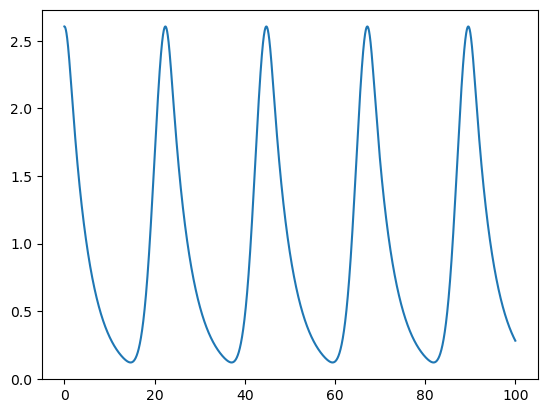

In [36]:
#########################################        
# This script initializes the Dovzhenok #
#       model using the ODE class       #
#########################################

#The command below is only necessary if ODE.py is up one directory

# Sympy variables
Mf = sympy.Symbol('Mf')   # State frq mRNA
Fc = sympy.Symbol('Fc')   # State FRQ cyt
Fn = sympy.Symbol('Fn')   # State FRQ nuc
Mw = sympy.Symbol('Mw')   # State wc-1 mRNA
Wc = sympy.Symbol('Wc')   # State WC-1 cyt
Wn = sympy.Symbol('Wn')   # State WC-1 nuc
FWn = sympy.Symbol('FWn') # State FRQ:WC-1 nuc
Mc = sympy.Symbol('Mc')   # State csp-1 mRNA
C = sympy.Symbol('C')     # State CSP-1
Y = sympy.Matrix([Mf, Fc, Fn, Mw,        # State variables
                  Wc, Wn, FWn, Mc, C])

# Sympy parameters
k1 = sympy.Symbol('k1')
k2 = sympy.Symbol('k2')
k3 = sympy.Symbol('k3')
k4 = sympy.Symbol('k4')
k5 = sympy.Symbol('k5')
k6 = sympy.Symbol('k6')
k7 = sympy.Symbol('k7')
k8 = sympy.Symbol('k8')
k9 = sympy.Symbol('k9')
k10 = sympy.Symbol('k10')
k11 = sympy.Symbol('k11')
k12 = sympy.Symbol('k12')
k13 = sympy.Symbol('k13')
k14 = sympy.Symbol('k14')
k15 = sympy.Symbol('k15')
k16 = sympy.Symbol('k16')
k17 = sympy.Symbol('k17')
k18 = sympy.Symbol('k18')
k19 = sympy.Symbol('k19')
J = sympy.Symbol('J')
J1 = sympy.Symbol('J1')
J2 = sympy.Symbol('J2')
J3 = sympy.Symbol('J3')
J4 = sympy.Symbol('J4')
r = sympy.Symbol('r')
k = sympy.Symbol('k')
p_const = sympy.Symbol('p_const')

# Dictionary of sympy parameters and their values (pulsable)
p = {k1:1.8,   # k1
     k2:1.8,   # k2
     k3:0.05,  # k3
     k4:0.23,  # k4
     k5:0.27,  # k5
     k6:0.27,  # k6
     k7:0.5,   # k7
     k8:1.,    # k8
     k9:40.,   # k9
     k10:0.1,   # k10
     k11:0.05,  # k11
     k12:0.02,  # k12
     k13:50.,   # k13
     k14:1.,    # k14
     k15:5.,    # k15
     k16:0.12,  # k16
     k17:1.4,   # k17
     k18:50.,   # k18
     k19:1.4,   # k19
     J:1.25,   # J
     J1:3.,    # J1
     J2:1.,    # J2
     J3:10.,   # J3
     J4:3.,    # J4
     r:1.,     # r
     k:6.,     # k
     p_const:2.} # p_const
# Constant pulsing parameters
qMf = sympy.Symbol('qMf')
qFc = sympy.Symbol('qFc')
qFn = sympy.Symbol('qFn')
qMw = sympy.Symbol('qMw')
qWc = sympy.Symbol('qWc')
qWn = sympy.Symbol('qWn')
qFWn = sympy.Symbol('qFWn')
qMc = sympy.Symbol('qMc')
qC = sympy.Symbol('qC')

# Parameters as additive pulses           
p_add = [qMf, qFc, qFn, qMw, qWc, qWn, qFWn, qMc, qC]

# Symbolic ODE RHS
dMf = k1*(Wn**k)/(J+Wn**k)-k4*Mf
dFc = k2*Mf-(k3+k5)*Fc
dFn = k3*Fc+k14*FWn-Fn*(k6+k13*Wn) 
dMw = k7*(J1**r)/(J1**r+C**r)-k10*Mw
dWc = k8*(Fc**p_const)*Mw/((J3+Mw)*(J2+Fc**p_const))-(k9+k11)*Wc
dWn = k9*Wc-Wn*(k12+k13*Fn)+k14*FWn
dFWn = k13*Fn*Wn-(k14+k15)*FWn
dMc = k16*Wn*(J4**r)/(J4**r+C**r)-k17*Mc
dC = k18*Mc-k19*C
dY = sympy.Matrix([dMf, dFc, dFn, dMw,
                   dWc, dWn, dFWn, dMc, dC])      # Vector ODE RHS

# Initial values on the limit cycle at frq mRNA max.
Y0 = np.array([2.60537964,    # Mf0,
               8.74143086,     # Fc0
               0.0110685024,  # Fn0
               3.70361114,    # Mw0
               0.00666226484, # Wc0
               0.924361228,   # Wn0
               0.0820481701,   # FWn0
               0.05214823,  # Mc0
               1.93780501])   # C0

frq_ind = 0

period = 22.3934820284

##### Below is example solving and plotting frq mRNA for Dovzhenok's model #####

ModDovzhenok = ODE('The Dovzhenok Model',frq_ind,Y,p,p_add,dY,Y0,period,findQ=False)

tot_time=100
t_test = np.linspace(0,tot_time, 100*tot_time)
sol_test = ModDovzhenok.solve(ModDovzhenok.lim_cyc_vals, t_test)
frq_sol = sol_test[:,frq_ind]
plt.plot(t_test, frq_sol)

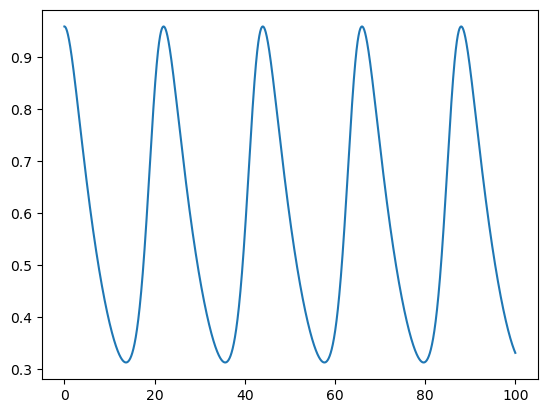

In [40]:
######################################        
# This script initializes the simple #
#    model using the ODE class       #
######################################

# Sympy variables
A = sympy.Symbol('A')   # frq mRNA (Fm)
B = sympy.Symbol('B')   # FRQ protein (Fp)
C = sympy.Symbol('C')   # WC-1:FRQ complex (W:Fp)
D = sympy.Symbol('D')   # WC-1 protein (W)
Y = sympy.Matrix([A, B, C, D]) # State Variables

# Sympy parameters
k1 = sympy.Symbol('k1')  # Constant synthesis of WC-1 protein
k2 = sympy.Symbol('k2')  # Degradation of WC-1 protein
k3 = sympy.Symbol('k3')  # Transcription of frq mRNA
k4 = sympy.Symbol('k4')  # Degradation of frq mRNA
k5 = sympy.Symbol('k5')  # Translation of frq mRNA
k6 = sympy.Symbol('k6')  # Degradation of FRQ
k7 = sympy.Symbol('k7')  # Dissociation of WC-1:FRQ complex
k8 = sympy.Symbol('k8')  # Association of WC-1:FRQ complex
k9 = sympy.Symbol('k9')  # Degradation of WC-1:FRQ complex
K = sympy.Symbol('K')    # Threshold for frq transcription function
m = sympy.Symbol('m')    # Hill-coefficient of frq transcription function

# Dictionary of sympy parameters and their values (pulsable)
p = {k1:0.161872619,
     k2:0.01205687,
     k3:5.896782858,
     k4:0.122630429,
     k5:0.320603032,
     k6:0.040189568,
     k7:0.017518666,
     k8:0.473989872,
     k9:0.52555997,
     K:0.924,
     m:7}

# Constant pulsing parameters
qA = sympy.Symbol('qA')
qB = sympy.Symbol('qB')
qC = sympy.Symbol('qC')
qD = sympy.Symbol('qD')

# Parameters as additive pulses           
p_add = [qA, qB, qC, qD]

# Symbolic ODE RHS
dA = k3*D**m/(K**m+D**m) - k4*A     # frq mRNA
dB = k5*A - k6*B + k7*C - k8*B*D    # FRQ Protein
dC = k8*B*D - k7*C - k9*C           # WC-1:FRQ complex
dD = k1 - k2*D + k7*C - k8*B*D      # WC-1 protein
dY = sympy.Matrix([dA, dB, dC, dD]) # Vector ODE RHS

# Initial values on the limit cycle at frq mRNA max.
Y0 = np.array([0.958658,   # A0
               0.7892854,  # B0
               0.3232268,  # C0
               0.5296776]) # D0

frq_ind = 0

period = 22.

##### Below is example solving and plotting frq mRNA for the simple model #####

ModSimple = ODE('The Simple Model',frq_ind,Y,p,p_add,dY,Y0,period,findQ=False)

tot_time=100
t_test = np.linspace(0,tot_time, 100*tot_time)
sol_test = ModSimple.solve(ModSimple.lim_cyc_vals, t_test)
frq_sol = sol_test[:,frq_ind]
plt.plot(t_test, frq_sol)